In [1]:
import numpy as np

import matplotlib.pyplot as plt



import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Subset

from torch.utils.data import DataLoader

from torch.utils.data import random_split



import torchvision

import torchvision.transforms as transforms



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import time



import importlib

import utils



importlib.reload(utils)

from utils.utils import (

    accuracy,

    train,

    combined_train,

    test,

    plot_acc,

    plot_loss,

    plot_confusion_matrix,

    save_model,

    get_feature_maps,

    visualize_feature_maps,

    plot_images,

    plot_feature_maps,

)

# Loading CIFAR-10 Dataset + Preprocess


In [2]:
class OneHotEncode:

    def __init__(self, num_classes):

        self.num_classes = num_classes



    def __call__(self, label):

        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [3]:
train_size = 50000

val_size = 10000

test_size = 10000

mean = [0.5, 0.5, 0.5]

std = [0.5, 0.5, 0.5]

num_classes = 10



torch.manual_seed(13)

np.random.seed(13)



transform = transforms.Compose(

    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]

)



label_transform = OneHotEncode(num_classes=num_classes)



train_dataset = torchvision.datasets.CIFAR10(

    root="./data",

    train=True,

    download=True,

    transform=transform,

    target_transform=label_transform,

)



test_dataset = torchvision.datasets.CIFAR10(

    root="./data",

    train=False,

    download=True,

    transform=transform,

    target_transform=label_transform,

)



train_subset, val_subset = random_split(

    train_dataset, [train_size - val_size, val_size]

)

test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

100%|██████████| 170498071/170498071 [00:03<00:00, 49428788.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
classes = train_dataset.classes

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Dataset Preview


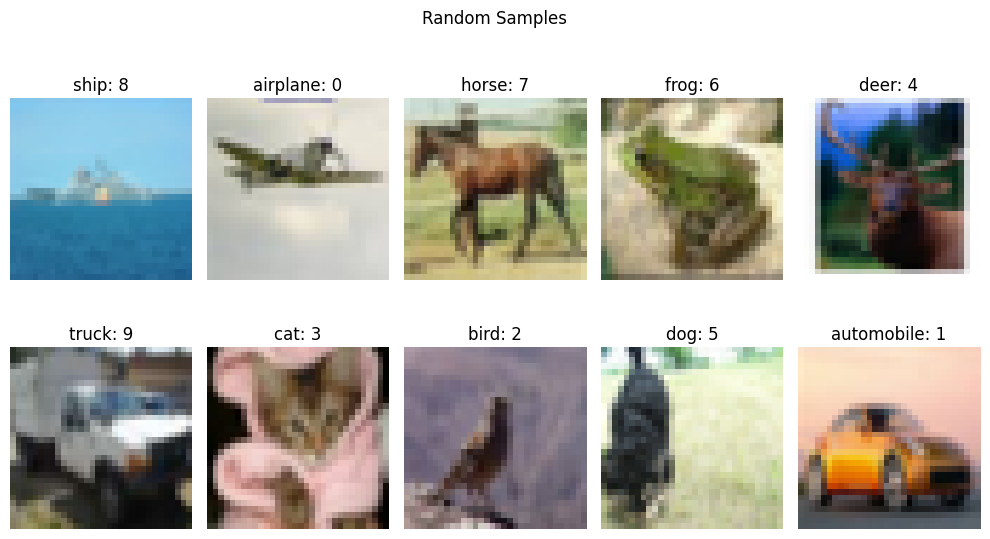

In [5]:
samples = {}



for image, label in train_subset:

    label = torch.argmax(label).item()

    if label not in samples:

        samples[f"{classes[label]}: {label}"] = image

    if len(samples) == len(classes):

        break



plot_images(list(samples.values()), mean, std, list(samples.keys()), "Random Samples")

## Data Loaders

In [6]:
train_loader = DataLoader(

    train_subset,

    batch_size=32,

    shuffle=True,

    num_workers=4,

    pin_memory=True,

    persistent_workers=True,

)

val_loader = DataLoader(

    val_subset,

    batch_size=32,

    shuffle=True,

    num_workers=4,

    pin_memory=True,

    persistent_workers=True,

)

test_loader = DataLoader(

    test_subset,

    batch_size=32,

    shuffle=True,

    num_workers=4,

    pin_memory=True,

    persistent_workers=True,

)

# Training Model


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device: {device.type}")

device: cuda


In [8]:
class BaselineModel(nn.Module):

    def __init__(self):

        super(BaselineModel, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64 * 14 * 14, 10)



    def forward(self, x):

        x = self.conv1(x)

        x = self.relu(x)

        x = self.maxpool(x)

        x = self.flatten(x)

        x = self.fc(x)

        return x





baseline_model = BaselineModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=baseline_model.parameters())

In [9]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = train(

    model=baseline_model,

    train_loader=train_loader,

    val_loader=val_loader,

    optimizer=optimizer,

    criterion=criterion,

    device=device,

    epochs=epochs,

    log=True,

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 48.725, Train acc: 0.478, Val loss: 48.133, Val acc: 0.481
Epoch 10/30, Train loss: 42.572, Train acc: 0.542, Val loss: 43.095, Val acc: 0.532
Epoch 15/30, Train loss: 39.19, Train acc: 0.581, Val loss: 40.418, Val acc: 0.562
Epoch 20/30, Train loss: 36.938, Train acc: 0.606, Val loss: 38.906, Val acc: 0.575
Epoch 25/30, Train loss: 35.129, Train acc: 0.626, Val loss: 37.467, Val acc: 0.595
Epoch 30/30, Train loss: 33.562, Train acc: 0.643, Val loss: 36.38, Val acc: 0.607
time: 241.53 seconds


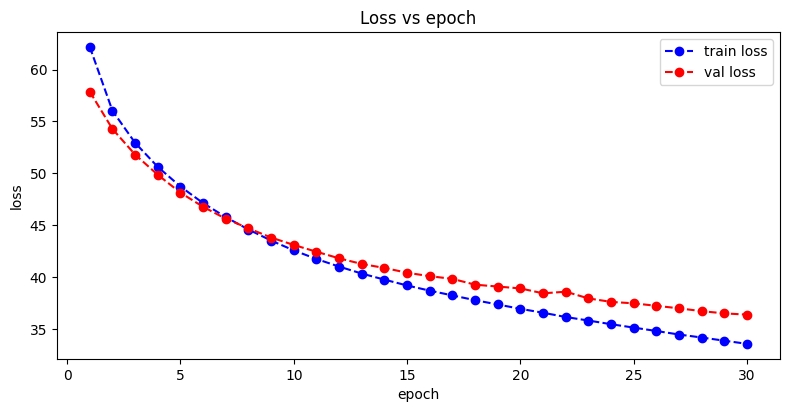

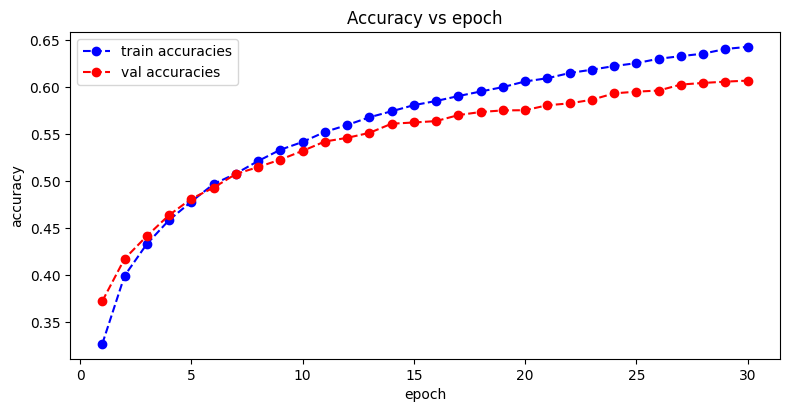

In [10]:
plot_loss(train_losses, validation_losses, epochs=epochs)

plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [11]:
save_model(baseline_model, "./baseline.pth")

model saved to ./baseline.pth successfully!


# Improving Model


In [12]:
class ImprovedModel(nn.Module):

    def __init__(self):

        super(ImprovedModel, self).__init__()



        self.relu1 = nn.ReLU()

        self.relu2 = nn.ReLU()

        self.relu3 = nn.ReLU()



        # 3 * 32 * 32 -> 64 * 30 * 30

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)

        # 64 * 29 * 29 -> 128 * 27 * 27

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        # 128 * 26 * 26 -> 256 * 24 * 24

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64 * 23 * 23, 10)



    def forward(self, x):

        x = self.conv1(x)

        x = self.relu1(x)

        x = self.maxpool1(x)

        x = self.conv2(x)

        x = self.relu2(x)

        x = self.maxpool2(x)

        x = self.conv3(x)

        x = self.relu3(x)

        x = self.maxpool3(x)

        x = self.flatten(x)

        x = self.fc(x)

        return x





improved_model = ImprovedModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=improved_model.parameters())

In [13]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = train(

    model=improved_model,

    train_loader=train_loader,

    val_loader=val_loader,

    optimizer=optimizer,

    criterion=criterion,

    device=device,

    epochs=epochs,

    log=True,

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1024 and 33856x10)

In [ ]:
plot_loss(train_losses, validation_losses, epochs=epochs)

plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [ ]:
save_model(improved_model, "./improvedmodel.pth")

# Adding Batch Normalization


In [ ]:
class BnModel(nn.Module):

    def __init__(self):

        super(BnModel, self).__init__()



        self.relu1 = nn.ReLU()

        self.relu2 = nn.ReLU()

        self.relu3 = nn.ReLU()



        # 3 * 32 * 32 -> 64 * 30 * 30

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(64)

        # 64 * 29 * 29 -> 128 * 27 * 27

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(128)

        # 128 * 26 * 26 -> 256 * 24 * 24

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(256)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64 * 23 * 23, 10)



    def forward(self, x):

        x = self.conv1(x)

        x = self.bn1(x)

        x = self.relu1(x)

        x = self.maxpool1(x)

        x = self.conv2(x)

        x = self.bn2(x)

        x = self.relu2(x)

        x = self.maxpool2(x)

        x = self.conv3(x)

        x = self.bn3(x)

        x = self.relu3(x)

        x = self.maxpool3(x)

        x = self.flatten(x)

        x = self.fc(x)

        return x





bn_model = BnModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=bn_model.parameters())

In [ ]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = train(

    model=bn_model,

    train_loader=train_loader,

    val_loader=val_loader,

    optimizer=optimizer,

    criterion=criterion,

    device=device,

    epochs=epochs,

    log=True,

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

In [ ]:
plot_loss(train_losses, validation_losses, epochs=epochs)

plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

#TODO

In [ ]:
save_model(bn_model, "./bnmodel.pth")

# Adding Dropout


In [ ]:
class DoModel(nn.Module):

    def __init__(self):

        super(DoModel, self).__init__()



        self.relu1 = nn.ReLU()

        self.relu2 = nn.ReLU()

        self.relu3 = nn.ReLU()



        # 3 * 32 * 32 -> 64 * 30 * 30

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(64)

        # 64 * 29 * 29 -> 128 * 27 * 27

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(128)

        # 128 * 26 * 26 -> 256 * 24 * 24

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(256)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.flatten = nn.Flatten()

        self.dropout = nn.Dropout(p=0.2, inplace=False)

        self.fc = nn.Linear(64 * 23 * 23, 10)



    def forward(self, x):

        x = self.conv1(x)

        x = self.bn1(x)

        x = self.relu1(x)

        x = self.maxpool1(x)

        x = self.conv2(x)

        x = self.bn2(x)

        x = self.relu2(x)

        x = self.maxpool2(x)

        x = self.conv3(x)

        x = self.bn3(x)

        x = self.relu3(x)

        x = self.maxpool3(x)

        x = self.flatten(x)

        x = self.dropout(x)

        x = self.fc(x)

        return x





do_model = DoModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=do_model.parameters())

In [ ]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = train(

    model=do_model,

    train_loader=train_loader,

    val_loader=val_loader,

    optimizer=optimizer,

    criterion=criterion,

    device=device,

    epochs=epochs,

    log=True,

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

In [ ]:
plot_loss(train_losses, validation_losses, epochs=epochs)

plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

#TODO

In [ ]:
save_model(bn_model, "./domodel.pth")

# Test and Confusion Matrix


In [ ]:
base_loss, base_accuracy, base_preds, base_labels = test(

    model=baseline_model, test_loader=test_loader, criterion=criterion, device=device

)

print("baseline model:")

print(f"loss= {np.round(base_loss, 3)}, accuracy= {np.round(base_accuracy, 3)}")

plot_confusion_matrix(

    base_labels, base_preds, class_names=classes, title="baseline model"

)





improved_loss, improved_accuracy, improved_preds, improved_labels = test(

    model=improved_model, test_loader=test_loader, criterion=criterion, device=device

)

print("improved model:")

print(f"loss= {np.round(improved_loss, 3)}, accuracy= {np.round(improved_accuracy, 3)}")

plot_confusion_matrix(

    improved_labels, improved_preds, class_names=classes, title="improved model"

)





bn_loss, bn_accuracy, bn_preds, bn_labels = test(

    model=bn_model, test_loader=test_loader, criterion=criterion, device=device

)

print("batch normalization model")

print(f"loss= {np.round(bn_loss, 3)}, accuracy= {np.round(bn_accuracy, 3)}")

plot_confusion_matrix(

    bn_labels, bn_preds, class_names=classes, title="batch normalization model"

)





do_loss, do_accuracy, do_preds, do_labels = test(

    model=do_model, test_loader=test_loader, criterion=criterion, device=device

)

print("dropout model")

print(f"loss= {np.round(do_loss, 3)}, accuracy= {np.round(do_accuracy, 3)}")

plot_confusion_matrix(do_labels, do_preds, class_names=classes, title="dropout model")